In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from datetime import datetime, timedelta

/Users/jteruya/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Matlab Plot Settings

In [2]:
# Display Plot within Jupyter Notebook
%matplotlib inline
# Default Plot Size
plt.rcParams['figure.figsize'] = [10, 10]

## Index Data

In [21]:
# Helper Function
def download_data(ticker, start, end):
    return yf.download(ticker, start, end)

# Start and End Dates for Ticker Data
start_date = "2018-01-01"
end_date = "2021-02-15"
# List of Indices to Retrieve Data
indices = ["^VIX", "^GSPC", "^DJI", "^TNX", "DX-Y.NYB", "GLD", "TIP", "VNQ"]
# List of lists
indices_data = [download_data(index, start_date, end_date) for index in indices]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Percent Movement Per Index
Calculate the % change for each day

In [22]:
# Previous Closing
def previous_close(df):
    df['Previous Close'] = df['Close'].shift(1)
    return df

# Percent Movement Helper Function
def market_movement(row):
    return (row['Close'] - row['Previous Close'])/row['Previous Close']

# Get Previous Close to Account for Futures
indices_data_prev = [previous_close(df) for df in indices_data]

# Apply helper function to all index dataframes
percent_movement = [index.apply(market_movement, axis=1) for index in indices_data_prev]

## Visualize Percent Market Per Day

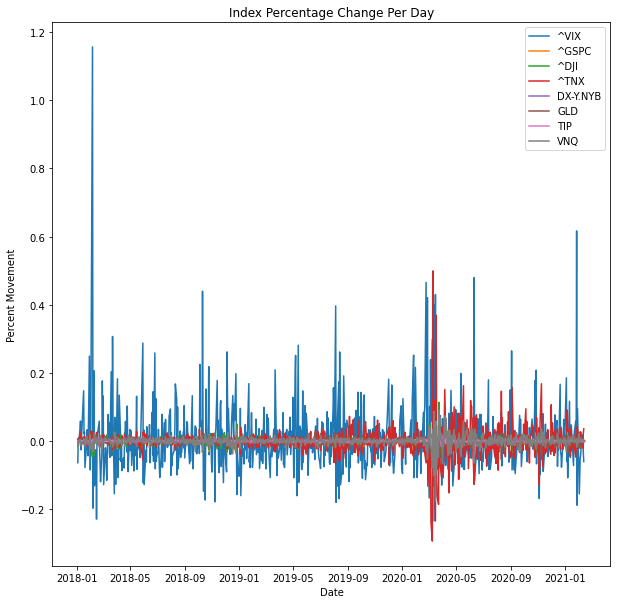

In [23]:
for x in range(len(indices)):
    plt.plot(percent_movement[x], label=indices[x])
plt.xlabel('Date')
plt.ylabel('Percent Movement')
plt.title('Index Percentage Change Per Day')
plt.legend()
plt.show()

## Create Daily Dataframe for Correlation Calculations

In [24]:
# Inital Correlation Dataframe
all_indices_df = pd.concat(percent_movement, axis=1)
all_indices_df.columns = [index[1:] + " Percent Movement" for index in indices]
original_columns = all_indices_df.columns
all_indices_df['Day'] = all_indices_df.index

# Add Timeshifts (by Day)
max_shift = 4
for shift in range(1, max_shift):
    for column in original_columns:
        all_indices_df[column + " + " + str(shift) + " Day Shift"] = all_indices_df[column].shift(-shift)

# Direction Change
all_indices_df['GSPC Same Direction'] = (all_indices_df['GSPC Percent Movement'].shift(1) > 0)^(all_indices_df['GSPC Percent Movement'] < 0)
all_indices_df['VIX Same Direction'] = (all_indices_df['VIX Percent Movement'].shift(1) > 0)^(all_indices_df['VIX Percent Movement'] < 0)
        
# Directional Streak ID
all_indices_df['GSPC Streak'] = 0
all_indices_df['VIX Streak'] = 0

all_indices_df['GSPC Streak'] = all_indices_df.apply(lambda x: 1 if not(x['GSPC Same Direction']) else x['GSPC Streak'], axis=1).cumsum()
all_indices_df['VIX Streak'] = all_indices_df.apply(lambda x: 1 if not(x['VIX Same Direction']) else x['VIX Streak'], axis=1).cumsum()

# Count the consecutive days of a particular streak
all_indices_df['GSPC Streak Consecutive Days'] = all_indices_df.groupby("GSPC Streak")['Day'].rank("dense", ascending=True)
all_indices_df['VIX Streak Consecutive Days'] = all_indices_df.groupby("VIX Streak")['Day'].rank("dense", ascending=True)

# Dependent Variable
all_indices_df['VIX Same Direction Next Day'] = all_indices_df['VIX Same Direction'].shift(-1)

# Correlations on Columns
all_indices_df.tail(10)

,VIX Percent Movement,GSPC Percent Movement,DJI Percent Movement,TNX Percent Movement,X-Y.NYB Percent Movement,LD Percent Movement,IP Percent Movement,NQ Percent Movement,Day,VIX Percent Movement + 1 Day Shift,...,LD Percent Movement + 3 Day Shift,IP Percent Movement + 3 Day Shift,NQ Percent Movement + 3 Day Shift,GSPC Same Direction,VIX Same Direction,GSPC Streak,VIX Streak,GSPC Streak Consecutive Days,VIX Streak Consecutive Days,VIX Same Direction Next Day
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-02,-0.154762,0.013898,0.015741,0.025998,0.001978,-0.012168,0.001488,0.005984,2021-02-02,-0.103678,...,0.009872,-0.000235,0.003531,True,True,404,406,2.0,2.0,True
2021-02-03,-0.103678,0.001009,0.001177,0.023529,-0.000877,-0.001511,-0.000547,-0.002517,2021-02-03,-0.049760,...,0.010070,0.000940,0.005448,True,True,404,406,3.0,3.0,True
2021-02-04,-0.049760,0.010853,0.010814,0.007073,0.004500,-0.021530,-0.000704,0.006881,2021-02-04,-0.041341,...,0.003265,0.000548,0.003499,True,True,404,406,4.0,4.0,True
2021-02-05,-0.041341,0.003897,0.002975,0.027217,-0.005353,0.009872,-0.000235,0.003531,2021-02-05,0.017729,...,0.003661,0.000860,0.005399,True,True,404,406,5.0,5.0,False
2021-02-08,0.017729,0.007399,0.007625,-0.008547,-0.001208,0.010070,0.000940,0.005448,2021-02-08,0.018362,...,-0.008685,-0.001172,0.002126,True,False,404,407,6.0,1.0,True
2021-02-09,0.018362,-0.001114,-0.000316,-0.002586,-0.005389,0.003265,0.000548,0.003499,2021-02-09,0.016644,...,-0.003037,-0.001642,0.000223,False,True,405,407,1.0,2.0,True
2021-02-10,0.016644,-0.000345,0.001975,-0.020743,-0.000774,0.003661,0.000860,0.005399,2021-02-10,-0.033652,...,NaN,NaN,NaN,True,True,405,407,2.0,3.0,False
2021-02-11,-0.033652,0.001662,-0.000226,0.022065,0.000553,-0.008685,-0.001172,0.002126,2021-02-11,-0.060235,...,NaN,NaN,NaN,False,False,406,408,1.0,1.0,True
2021-02-12,-0.060235,0.004711,0.000881,0.036269,0.000664,-0.003037,-0.001642,0.000223,2021-02-12,NaN,...,NaN,NaN,NaN,True,True,406,408,2.0,2.0,False


## Preprocessing

In [25]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

independent_variables = ['GSPC Percent Movement', 'TNX Percent Movement', 'X-Y.NYB Percent Movement', 'LD Percent Movement', 'IP Percent Movement', 'NQ Percent Movement']

X = all_indices_df[independent_variables][2:-2]
y = all_indices_df['VIX Same Direction Next Day'][2:-2]

# Fill Non null values with mean
X.fillna(X.mean(), inplace=True)

# Categorical Label Encoder for Dependent Variable
le = preprocessing.LabelEncoder()

# Encode Categorical Dependent Variable
le.fit(y)
y = le.transform(y)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## Random Forest Directional Model

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=0, shuffle=False)

clf = RandomForestClassifier(max_depth=4, random_state=0)

# Train the Model
model = clf.fit(X_train, y_train)

model.predict(X_test)
model.predict_proba(X_test)

# Score the Model
model.score(X_test, y_test)

0.5987261146496815

## Feature Importance

<BarContainer object of 6 artists>

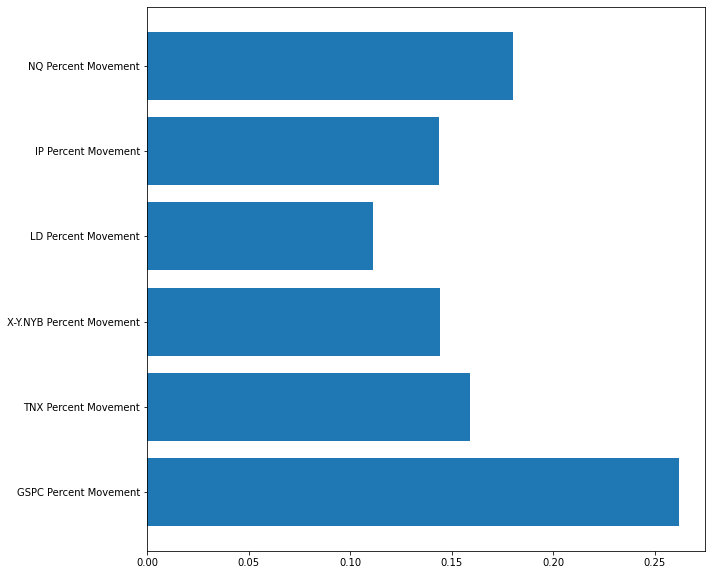

In [27]:
plt.barh(independent_variables, clf.feature_importances_)

In [30]:
# Prediction
base = datetime(2021,2,15)
date_list = [base - timedelta(days=x) for x in range(100)]

for date in date_list:
    date_index = date.strftime("%Y-%m-%d")
    try:
        print(date_index)
        print(model.predict_proba([all_indices_df.loc[date_index][independent_variables]]))
        print(model.predict([all_indices_df.loc[date_index][independent_variables]]))
    except:
        print("No Trading Day")
        pass
    print("\n")

2021-02-15
No Trading Day


2021-02-14
No Trading Day


2021-02-13
No Trading Day


2021-02-12
[[0.44359176 0.55640824]]
[1]


2021-02-11
[[0.46645301 0.53354699]]
[1]


2021-02-10
[[0.47161488 0.52838512]]
[1]


2021-02-09
[[0.43243209 0.56756791]]
[1]


2021-02-08
[[0.41157128 0.58842872]]
[1]


2021-02-07
No Trading Day


2021-02-06
No Trading Day


2021-02-05
[[0.41361978 0.58638022]]
[1]


2021-02-04
[[0.43179052 0.56820948]]
[1]


2021-02-03
[[0.44961522 0.55038478]]
[1]


2021-02-02
[[0.39314795 0.60685205]]
[1]


2021-02-01
[[0.40564235 0.59435765]]
[1]


2021-01-31
No Trading Day


2021-01-30
No Trading Day


2021-01-29
[[0.61072101 0.38927899]]
[0]


2021-01-28
[[0.39096386 0.60903614]]
[1]


2021-01-27
[[0.72458315 0.27541685]]
[0]


2021-01-26
[[0.50310466 0.49689534]]
[0]


2021-01-25
[[0.52553586 0.47446414]]
[0]


2021-01-24
No Trading Day


2021-01-23
No Trading Day


2021-01-22
[[0.54166268 0.45833732]]
[0]


2021-01-21
[[0.48579248 0.51420752]]
[1]


2021-01-20
[[0.37

## Logisitical Regression Directional Model

In [11]:
from sklearn.linear_model import LogisticRegression

# Train the Model
model = LogisticRegression(random_state=0).fit(X_train, y_train)

model.predict(X_test)
model.predict_proba(X_test)

# Score the Model
model.score(X_test, y_test)

0.5789473684210527

## Save Model

In [12]:
model_file_handler = open("models/vix_prediction.pl",'wb')
pickle.dump(model, model_file_handler)
model_file_handler.close()

## Prediction

In [13]:
model_file_handler = open("models/vix_prediction.pl",'rb')
model = pickle.load(model_file_handler)

In [20]:
# Prediction
base = datetime(2021,2,1)
date_list = [base - timedelta(days=x) for x in range(100)]

for date in date_list:
    date_index = date.strftime("%Y-%m-%d")
    try:
        print(date_index)
        print(model.predict_proba([all_indices_df.loc[date_index][independent_variables]]))
        print(model.predict([all_indices_df.loc[date_index][independent_variables]]))
    except:
        print("No Trading Day")
        pass
    print("\n")

2021-02-01
No Trading Day


2021-01-31
No Trading Day


2021-01-30
No Trading Day


2021-01-29
No Trading Day


2021-01-28
No Trading Day


2021-01-27
No Trading Day


2021-01-26
No Trading Day


2021-01-25
No Trading Day


2021-01-24
No Trading Day


2021-01-23
No Trading Day


2021-01-22
No Trading Day


2021-01-21
No Trading Day


2021-01-20
No Trading Day


2021-01-19
No Trading Day


2021-01-18
No Trading Day


2021-01-17
No Trading Day


2021-01-16
No Trading Day


2021-01-15
No Trading Day


2021-01-14
No Trading Day


2021-01-13
No Trading Day


2021-01-12
No Trading Day


2021-01-11
No Trading Day


2021-01-10
No Trading Day


2021-01-09
No Trading Day


2021-01-08
No Trading Day


2021-01-07
No Trading Day


2021-01-06
No Trading Day


2021-01-05
No Trading Day


2021-01-04
No Trading Day


2021-01-03
No Trading Day


2021-01-02
No Trading Day


2021-01-01
No Trading Day


2020-12-31
No Trading Day


2020-12-30
No Trading Day


2020-12-29
No Trading Day


2020-12-28
No Tradin

## Calculate Correlations

In [15]:
# Correlations on Columns
all_indices_df.corr(method ='pearson')

,VIX Percent Movement,GSPC Percent Movement,DJI Percent Movement,TNX Percent Movement,X-Y.NYB Percent Movement,LD Percent Movement,IP Percent Movement,NQ Percent Movement,VIX Percent Movement + 1 Day Shift,GSPC Percent Movement + 1 Day Shift,...,X-Y.NYB Percent Movement + 3 Day Shift,LD Percent Movement + 3 Day Shift,IP Percent Movement + 3 Day Shift,NQ Percent Movement + 3 Day Shift,GSPC Same Direction,VIX Same Direction,GSPC Streak,VIX Streak,GSPC Streak Consecutive Days,VIX Streak Consecutive Days
VIX Percent Movement,1.000000,-0.686983,-0.659539,-0.245428,-0.000301,0.002260,0.036290,-0.453055,-0.073074,0.104415,...,0.065315,0.008421,-0.048631,-0.059687,0.075593,-0.037816,-0.020336,-0.018079,0.101443,-0.058145
GSPC Percent Movement,-0.686983,1.000000,0.978139,0.418096,-0.030454,0.060806,-0.094443,0.796948,0.135580,-0.264882,...,-0.081446,-0.014716,0.055577,-0.002607,-0.029246,-0.013943,0.028440,0.027185,-0.038729,0.010577
DJI Percent Movement,-0.659539,0.978139,1.000000,0.422924,-0.042575,0.043154,-0.085541,0.798044,0.131202,-0.250726,...,-0.089638,-0.003202,0.031458,-0.008990,-0.023078,-0.009039,0.023175,0.021644,-0.030831,0.014765
TNX Percent Movement,-0.245428,0.418096,0.422924,1.000000,0.179227,-0.261302,-0.522920,0.319238,0.085197,-0.203435,...,0.006046,0.064964,0.176419,-0.030024,-0.027036,-0.003661,0.015286,0.013517,-0.024370,0.010035
X-Y.NYB Percent Movement,-0.000301,-0.030454,-0.042575,0.179227,1.000000,-0.444112,-0.161013,-0.061520,0.042325,-0.119906,...,0.000655,0.101724,0.095518,0.101805,-0.124033,-0.099300,-0.063346,-0.062845,-0.106275,-0.068781
LD Percent Movement,0.002260,0.060806,0.043154,-0.261302,-0.444112,1.000000,0.328395,0.098531,-0.033729,0.076738,...,-0.111522,-0.035071,0.050222,0.029580,0.032576,0.017451,0.043016,0.044688,0.018857,0.029932
IP Percent Movement,0.036290,-0.094443,-0.085541,-0.522920,-0.161013,0.328395,1.000000,0.039257,-0.048421,0.111932,...,-0.124932,0.053587,-0.164249,0.220977,0.026187,0.043090,0.045006,0.045195,0.008214,0.008805
NQ Percent Movement,-0.453055,0.796948,0.798044,0.319238,-0.061520,0.098531,0.039257,1.000000,0.085832,-0.197300,...,-0.070000,-0.002996,0.014909,-0.028659,-0.014662,-0.008112,0.005759,0.004124,-0.031127,-0.003735
VIX Percent Movement + 1 Day Shift,-0.073074,0.135580,0.131202,0.085197,0.042325,-0.033729,-0.048421,0.085832,1.000000,-0.686983,...,-0.013591,-0.033091,-0.055060,-0.131888,0.047423,-0.018523,-0.020001,-0.018242,0.051102,0.007036
GSPC Percent Movement + 1 Day Shift,0.104415,-0.264882,-0.250726,-0.203435,-0.119906,0.076738,0.111932,-0.197300,-0.686983,1.000000,...,0.006620,0.038135,-0.015138,0.227011,0.017396,0.042612,0.028315,0.027129,0.000289,0.013002


## Monthly Correlations

In [16]:
all_indices_df = pd.concat(percent_movement, axis=1)
all_indices_df.columns = [index[1:] + " Percent Movement" for index in indices]
all_indices_df['Month'] = all_indices_df.index.year * 100 + all_indices_df.index.month

months = all_indices_df['Month'].unique().tolist()

max_shift = 4
for shift in range(1, max_shift):
    for column in original_columns:
        all_indices_df[column + " + " + str(shift) + " Day Shift"] = all_indices_df[column].shift(-shift)

all_indices_df = all_indices_df.groupby(['Month']).corr(method ='pearson')

vix = []
dji = []
vix_1 = []
dji_1 = []
vix_2 = []
dji_2 = []
vix_3 = []
dji_3 = []

for month in months:
    monthly_indices_df = all_indices_df.loc[month, "GSPC Percent Movement"]
    vix.append(monthly_indices_df['VIX Percent Movement'])
    dji.append(monthly_indices_df['DJI Percent Movement'])
    vix_1.append(monthly_indices_df['VIX Percent Movement + 1 Day Shift'])
    dji_1.append(monthly_indices_df['DJI Percent Movement + 1 Day Shift'])
    vix_2.append(monthly_indices_df['VIX Percent Movement + 2 Day Shift'])
    dji_2.append(monthly_indices_df['DJI Percent Movement + 2 Day Shift'])
    vix_3.append(monthly_indices_df['VIX Percent Movement + 3 Day Shift'])
    dji_3.append(monthly_indices_df['DJI Percent Movement + 3 Day Shift'])
    
monthly_data = {'MONTH': [datetime.strptime(str(month), '%Y%m') for month in months], 'VIX': vix, 'DOW': dji, 'VIX+1': vix_1, 'DJI+1': dji_1, 'VIX+2': vix_2, 'DJI+2': dji_2, 'VIX+3': vix_3, 'DJI+3': dji_3}
monthly_df = pd.DataFrame(data = monthly_data).set_index('MONTH')
#monthly_df.to_csv('sp500_correlation_raw.csv')
monthly_df


,VIX,DOW,VIX+1,DJI+1,VIX+2,DJI+2,VIX+3,DJI+3
MONTH,,,,,,,,
2018-01-01,-0.584461,0.908449,0.537106,-0.091086,0.126839,-0.053346,-0.257324,0.398595
2018-02-01,-0.812976,0.987910,-0.163447,0.096323,0.199126,-0.356527,-0.158202,0.252710
2018-03-01,-0.871461,0.966292,0.291003,-0.234796,0.173830,-0.202881,-0.462713,0.371453
2018-04-01,-0.911940,0.978210,0.061317,-0.201744,0.228598,-0.242843,0.156660,-0.124479
2018-05-01,-0.793973,0.950399,0.224833,-0.316489,-0.153256,0.149362,0.169517,0.022289
2018-06-01,-0.926272,0.896844,0.273717,0.030988,-0.496409,0.468370,0.215291,0.010169
2018-07-01,-0.849138,0.871366,-0.030024,0.171743,0.322803,0.020957,0.113434,-0.180847
2018-08-01,-0.818560,0.884968,0.099037,-0.061710,-0.121774,0.120792,0.009906,-0.191299
2018-09-01,-0.765297,0.826566,-0.191978,0.223079,0.434898,0.013413,0.063894,-0.162571


## Plot Monthly Correlations over Time for SP500

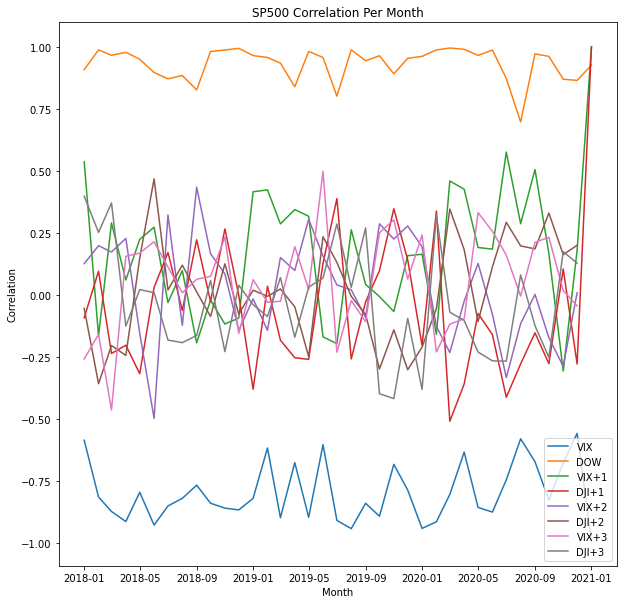

In [17]:
for x in range(len(monthly_df.columns)):
    plt.plot(monthly_df[monthly_df.columns[x]], label=monthly_df.columns[x])
plt.xlabel('Month')
plt.ylabel('Correlation')
plt.title('SP500 Correlation Per Month')
plt.legend()
plt.show()